In [14]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from tb_colormaps import * 

plt.style.use('bursa.mplstyle')

######################## PATH CONFIG ################################

df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
FIGURE_OUTDIR = 'analysis/figures/si figures/'

######################## ############ ################################

tissue_indices = {'P':0,
                  'B':1,
                  'L':2,
                  'S':3
                 }


df = pd.read_table(df_loc, usecols = ['sample_uid',
                                  'sample_uid_gex',
                                  'vdj_sequence',
                                  'n_umis',
                                  'v_pident',
                                  'donor',
                                  'tissue',
                                  'locus',
                                  'contaminant_status',
                                  'multiplet_status',
                                  'probable_hq_single_b_cell',
                                  'vdj_is_from_ambient',
                                  'is_ambient_source'], 
                                                nrows=None)



/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_44456/418428226.py:26: DtypeWarning: Columns (2,4,83,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(df_loc, usecols = ['sample_uid',


In [15]:
print('Starting with', df.shape[0], 'VDJ sequences')
df = df[df.vdj_sequence.notna()]
df = df[df.contaminant_status.isin(['unlikely_contaminant','source'])]
print('After dropping contaminants and VDJ-free droplets: ', df.shape[0])

acceptable_cells = ((~(df.vdj_is_from_ambient==True).astype(bool)) 
                    | (df.is_ambient_source==True).astype(bool))
df = df[acceptable_cells]
print('After dropping ambient: ', df.shape[0])



Starting with 1460060 VDJ sequences
After dropping contaminants and VDJ-free droplets:  1160737
After dropping ambient:  1158331


In [16]:
df['is_overloaded'] = df.sample_uid_gex.isna()
df['is_overloaded'] = df.is_overloaded.map({True:"VDJ only", False:"VDJ+GEX"})
multiplet_counts = df.groupby(['sample_uid','tissue','is_overloaded'])['multiplet_status'].value_counts(normalize=True)


In [17]:
multiplet_counts.name = 'fraction'
multiplet_counts = multiplet_counts.reset_index()


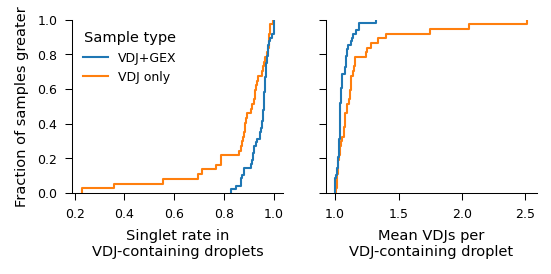

In [22]:
fig, ax = plt.subplots(1,2, figsize=(4,1.5), sharey=True)
g = sns.ecdfplot(data=multiplet_counts[multiplet_counts.multiplet_status==1],
             x='fraction',
            hue='is_overloaded',
            stat='proportion',
            ax=ax[0])
ax[0].set_xlabel('Singlet rate in\nVDJ-containing droplets')
ax[0].set_ylabel('Fraction of samples greater')
sns.despine(fig)
sns.move_legend(g, frameon=False, loc='upper left', title='Sample type')

multiplet_counts['weight'] = multiplet_counts.multiplet_status * multiplet_counts.fraction
mean_multiplicity = multiplet_counts.groupby(['sample_uid', 'is_overloaded'])['weight'].sum()

sns.ecdfplot(mean_multiplicity.reset_index(), x='weight', hue='is_overloaded', ax=ax[1], legend=False)
ax[1].set_xlabel('Mean VDJs per\nVDJ-containing droplet')

fig.savefig('../figures/si figures/droplet_multiplicity.pdf', bbox_inches='tight')


In [19]:
high_multiplicity_samples = multiplet_counts[(multiplet_counts.multiplet_status==1) & (multiplet_counts.fraction<0.8)]
high_multiplicity_samples

,sample_uid,tissue,is_overloaded,multiplet_status,fraction,weight
126,TBd4_frozen_BMover_HTa,BM,VDJ only,1,0.696248,0.696248
130,TBd4_frozen_BMover_HTb,BM,VDJ only,1,0.710990,0.710990
148,TBd5_fresh_BM_a,BM,VDJ only,1,0.227210,0.227210
153,TBd5_fresh_BM_b,BM,VDJ only,1,0.356110,0.356110
167,TBd5_fresh_SP,SP,VDJ only,1,0.768243,0.768243
223,TBd6_fresh_BMover,BM,VDJ only,1,0.553303,0.553303
243,TBd6_fresh_SDLN3over,LN,VDJ only,1,0.788646,0.788646
251,TBd6_fresh_SPover,SP,VDJ only,1,0.788401,0.788401
